In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


In [3]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostRegressor
import xgboost as xg 

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, LSTM

import warnings
warnings.filterwarnings('ignore')

In [5]:
# For Bayesian Optimization
import optuna

In [6]:
df = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
# df.head()

In [ ]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")
# df_test.head()

In [ ]:
df.info()

In [ ]:
df.describe().round(1)

In [ ]:
# plt.plot(df['Age'].sort_values().reset_index(drop=True))

non_object_columns = ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']

for non_object_column in non_object_columns:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.distplot(a=df[non_object_column])
    plt.subplot(1, 2, 2)
    sns.distplot(a=df_test[non_object_column])
    # plt.title(non_object_column)
    plt.show()

In [ ]:
df.isna().sum().sort_values(ascending=False)

In [ ]:
df_dropna = df.dropna().reset_index()

non_object_columns = ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']

for non_object_column in non_object_columns:
    plt.figure(figsize=(15, 4))
    
    plt.subplot(1, 3, 1)
    sns.distplot(a=df[non_object_column])
    
    plt.subplot(1, 3, 2)
    sns.distplot(a=df_test[non_object_column])
    
    plt.subplot(1, 3, 3)
    sns.distplot(a=df_dropna[non_object_column])
    
    plt.show()

In [ ]:
# Previous Claims         364029 ------------- mean of above and below
# Occupation              358075 ------------- check test and train data
# Credit Score            137882 ------------- mean of above and below
# Number of Dependents    109672 ------------- mean of above and below
# Customer Feedback        77824 ------------- check test and train data
# Health Score             74076 ------------- mean of above and below
# Annual Income            44949 ------------- mean of above and below
# Age                      18705 ------------- mean of above and below
# Marital Status           18529 ------------- check test and train data
# Vehicle Age                  6 ------------- mean of above and below
# Insurance Duration           1 ------------- mode

In [9]:
print(df.shape)
print(df_dropna.shape)
print(df_test.shape)

(1200000, 21)


NameError: name 'df_dropna' is not defined

In [10]:
df1 = df.copy()
print(df1.shape)
# df1.head()

(1200000, 21)


In [11]:
df1.drop(['id', 'Policy Start Date'], axis=1, inplace=True)

In [ ]:
df1['Occupation'].unique()

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
df1['Occupation'].value_counts(dropna=False).plot(kind='bar', rot=0)
plt.subplot(1, 2, 2)
df_test['Occupation'].value_counts(dropna=False).plot(kind='bar', rot=0)
plt.show()

In [ ]:
(df1.groupby('Occupation', dropna=False)['Premium Amount'].mean()).plot(kind='bar', rot=0)

In [ ]:
df1['Customer Feedback'].unique()

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
df1['Customer Feedback'].value_counts(dropna=False).plot(kind='bar', rot=0)
plt.subplot(1, 2, 2)
df_test['Customer Feedback'].value_counts(dropna=False).plot(kind='bar', rot=0)
plt.show()

In [ ]:
(df1.groupby('Customer Feedback', dropna=False)['Premium Amount'].mean()).plot(kind='bar', rot=0)

In [ ]:
df1[df1['Customer Feedback'].isna()]['Premium Amount']

In [ ]:
plt.subplot(2, 2, 1)
sns.distplot(a=(df1[df1['Customer Feedback'] == 'Average']['Premium Amount']))

plt.subplot(2, 2, 2)
sns.distplot(a=(df1[df1['Customer Feedback'] == 'Good']['Premium Amount']))

plt.subplot(2, 2, 3)
sns.distplot(a=(df1[df1['Customer Feedback'] == 'Poor']['Premium Amount']))

plt.subplot(2, 2, 4)
sns.distplot(a=(df1[df1['Customer Feedback'].isna()]['Premium Amount']))

In [ ]:
plt.boxplot(df1[df1['Customer Feedback'].isna()]['Premium Amount'])

In [ ]:
df1[df1['Customer Feedback'].isna()].isna().sum().sort_values(ascending=False)

In [ ]:
df1['Customer Feedback'].isna().sum()

In [ ]:
df1['Marital Status'].unique()

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
df1['Marital Status'].value_counts(dropna=False).plot(kind='bar', rot=0)
plt.subplot(1, 2, 2)
df_test['Marital Status'].value_counts(dropna=False).plot(kind='bar', rot=0)
plt.show()

In [ ]:
(df1.groupby('Marital Status', dropna=False)['Premium Amount'].mean()).plot(kind='bar', rot=0)

In [ ]:
plt.subplot(2, 2, 1)
sns.distplot(a=(df1[df1['Marital Status'] == 'Divorced']['Premium Amount']))

plt.subplot(2, 2, 2)
sns.distplot(a=(df1[df1['Marital Status'] == 'Married']['Premium Amount']))

plt.subplot(2, 2, 3)
sns.distplot(a=(df1[df1['Marital Status'] == 'Single']['Premium Amount']))

plt.subplot(2, 2, 4)
sns.distplot(a=(df1[df1['Marital Status'].isna()]['Premium Amount']))

In [ ]:
df1[df1['Customer Feedback'].isna() | df1['Marital Status'].isna()].isna().sum().sort_values(ascending=False)

In [ ]:
df1.dropna(subset=['Customer Feedback','Marital Status'], inplace=True)
df1 = df1.reset_index().drop(['index', 'id'], axis=1)
df1

In [ ]:
plt.figure(figsize=(7, 8))
plt.subplot(2, 1, 1)
df1['Occupation'].value_counts(dropna=False).plot(kind='bar', rot=0)
plt.subplot(2, 1, 2)
(df1.groupby('Occupation', dropna=False)['Premium Amount'].mean()).plot(kind='bar', rot=0)
plt.show()

In [ ]:
df1.isna().sum().sort_values(ascending=False)

In [ ]:
df1.select_dtypes("object")

In [ ]:
for i in df1.select_dtypes("object").columns:
    print(i, " "*(20-len(i)),df1[i].unique(), "\n")

In [ ]:
# Gender                     0 --------- 0 1
# Marital Status             0 --------- 0 1 OHE
# Education Level            0 --------- 0 1 OHE
# Occupation            329843 --------- 0 1 OHE
# Location                   0 --------- 0 1 OHE
# Policy Type                0 --------- -1 0 1
# Policy Start Date          0 --------- drop
# Customer Feedback          0 --------- -1 0 1
# Smoking Status             0 --------- 0 1
# Exercise Frequency         0 --------- 1 7 30
# Property Type              0 --------- 0 1 OHE

In [12]:
gender_dict = {'Female': 0,'Male': 1}
policy_type_dict = {'Basic': -1,'Premium': 0,'Comprehensive': 1}
# customer_feedback_dict = {'Poor': -1,'Average': 0,'Good': 1}
smoking_status_dict = {'No': 0,'Yes': 1}
# exercise_frequency_dict = {'Rarely': 1, 'Daily':0, 'Weekly':1/7, 'Monthly': 1/30}

In [13]:
df1['Gender'] = df1['Gender'].map(gender_dict)
df1['Policy Type'] = df1['Policy Type'].map(policy_type_dict)
# df1['Customer Feedback'] = df1['Customer Feedback'].map(customer_feedback_dict)
df1['Smoking Status'] = df1['Smoking Status'].map(smoking_status_dict)
# df1['Exercise Frequency'] = df1['Exercise Frequency'].map(exercise_frequency_dict)

In [ ]:
pd.get_dummies(df1['Customer Feedback'], dtype = int)

In [ ]:
pd.get_dummies(df1['Marital Status'], dtype = int)

In [ ]:
pd.get_dummies(df1['Education Level'], dtype = int).drop(['PhD'], axis=1)

In [ ]:
pd.get_dummies(df1['Occupation'], dtype = int)

In [ ]:
pd.get_dummies(df1['Location'], dtype = int).drop(['Suburban'], axis=1)

In [ ]:
pd.get_dummies(df1['Property Type'], dtype = int).drop(['Condo'], axis=1)

In [ ]:
df1.drop(['Policy Start Date'], axis=1, inplace=True)
df1

In [14]:
df2 = pd.concat(
    [
        df1.select_dtypes(exclude = "object"),
        pd.get_dummies(df1['Marital Status'], dtype = int),
        pd.get_dummies(df1['Education Level'], dtype = int).drop(['PhD'], axis=1),
        pd.get_dummies(df1['Occupation'], dtype = int),
        pd.get_dummies(df1['Location'], dtype = int).drop(['Suburban'], axis=1),
        pd.get_dummies(df1['Property Type'], dtype = int).drop(['Condo'], axis=1),
        pd.get_dummies(df1['Customer Feedback'], dtype = int),
        pd.get_dummies(df1['Exercise Frequency'], dtype = int).drop(['Rarely'], axis=1)     
    ],
    axis = "columns"
)
# df2

In [12]:
df2.isna().sum().sort_values(ascending=False)

Previous Claims         364029
Credit Score            137882
Number of Dependents    109672
Health Score             74076
Annual Income            44949
Age                      18705
Vehicle Age                  6
Insurance Duration           1
Monthly                      0
Self-Employed                0
Daily                        0
Poor                         0
Good                         0
Average                      0
House                        0
Apartment                    0
Urban                        0
Rural                        0
Unemployed                   0
Bachelor's                   0
Employed                     0
Master's                     0
High School                  0
Gender                       0
Single                       0
Married                      0
Divorced                     0
Premium Amount               0
Smoking Status               0
Policy Type                  0
Weekly                       0
dtype: int64

In [ ]:
def fill_nan_with_neighbors(series):
    for i in range(1, len(series) - 1):
        if pd.isna(series.iloc[i]):
            prev_value = series.iloc[i - 1]
            next_value = series.iloc[i + 1]
            if not pd.isna(prev_value) and not pd.isna(next_value):
                series.iloc[i] = (prev_value + next_value) / 2
    return series

In [ ]:
# Previous Claims         364029 ------------- mean of above and below
# Occupation              358075 ------------- check test and train data
# Credit Score            137882 ------------- mean of above and below
# Number of Dependents    109672 ------------- mean of above and below
# Customer Feedback        77824 ------------- check test and train data
# Health Score             74076 ------------- mean of above and below
# Annual Income            44949 ------------- mean of above and below
# Age                      18705 ------------- mean of above and below
# Marital Status           18529 ------------- check test and train data
# Vehicle Age                  6 ------------- mean of above and below
# Insurance Duration           1 ------------- mode

In [ ]:
df2['Previous Claims'] = fill_nan_with_neighbors(df2['Previous Claims'])
df2['Credit Score'] = fill_nan_with_neighbors(df2['Credit Score'])
df2['Number of Dependents'] = fill_nan_with_neighbors(df2['Number of Dependents'])
df2['Health Score'] = fill_nan_with_neighbors(df2['Health Score'])
df2['Annual Income'] = fill_nan_with_neighbors(df2['Annual Income'])
df2['Age'] = fill_nan_with_neighbors(df2['Age'])
df2['Vehicle Age'].fillna(df2['Vehicle Age'].mean(), inplace=True)
df2['Insurance Duration'].fillna(df2['Insurance Duration'].mode()[0], inplace=True)

In [ ]:
df2.fillna(df2.mean().to_dict(), inplace=True)

In [ ]:
np.log1p(df2['Annual Income'])

In [ ]:
df2

In [ ]:
df2.hist(figsize = (15,15))

In [ ]:
df2.isna().sum()

In [16]:
df2.to_csv("train_new.csv", index=False)

In [ ]:
df2 = pd.read_csv('/kaggle/working/train_new.csv')

In [ ]:
df2

In [15]:
df2['Annual Income'] = np.log1p(df2['Annual Income'])
df2['Health Score'] = np.log1p(df2['Health Score'])
df2['Credit Score'] = np.log1p(df2['Credit Score'])

In [15]:
df2

,Age,Gender,Annual Income,Number of Dependents,Health Score,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,...,Rural,Urban,Apartment,House,Average,Good,Poor,Daily,Monthly,Weekly
0,19.0,0,9.215328,1.0,3.161194,0,2.0,17.0,5.921578,5.0,...,0,1,0,1,0,0,1,0,0,1
1,39.0,0,10.363409,3.0,2.807578,1,1.0,12.0,6.543912,2.0,...,1,0,0,1,1,0,0,0,1,0
2,23.0,1,10.150465,3.0,3.874893,0,1.0,14.0,NaN,3.0,...,0,0,0,1,0,1,0,0,0,1
3,21.0,1,11.862568,2.0,2.479739,-1,1.0,0.0,5.908083,1.0,...,1,0,1,0,0,0,1,1,0,0
4,21.0,1,10.587897,1.0,3.062273,0,0.0,8.0,6.395262,4.0,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,0,10.215264,0.0,2.692795,0,NaN,5.0,5.921578,3.0,...,0,1,1,0,0,0,1,1,0,0
1199996,54.0,1,10.485340,NaN,2.524406,1,NaN,10.0,6.393591,4.0,...,1,0,1,0,0,0,1,0,0,1
1199997,19.0,1,10.856785,0.0,2.755218,-1,0.0,19.0,NaN,6.0,...,0,0,0,0,0,1,0,0,1,0
1199998,55.0,1,NaN,1.0,2.972841,0,1.0,7.0,6.011267,4.0,...,0,0,1,0,0,0,1,1,0,0


In [ ]:
df2.describe()

In [ ]:
df2.shape

In [ ]:
df2.isna().sum()

In [ ]:
sns.heatmap(df.isna().sort_values(by=["Occupation"]) == True)

In [ ]:
for non_object_column in df.select_dtypes(exclude = "object").columns:
    print(df[non_object_column].mean())

In [ ]:
for non_object_column in df.select_dtypes(exclude = "object").columns:
    if non_object_column != 'id':
        print(df[non_object_column].mode()[0])

In [ ]:
df['Age'].mode()[0]

In [ ]:
# df.dropna(inplace = True)
for non_object_column in df.select_dtypes(exclude = "object").columns:
    df[non_object_column].fillna(df[non_object_column].mode()[0], inplace = True)

df.dropna(inplace = True)

In [ ]:
df.shape

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(df.select_dtypes(exclude = "object").corr(), annot = True, cmap = "Reds")

In [ ]:
df_categorical = df.select_dtypes('object')
for object_column in df_categorical.columns:
    print(object_column, {df[object_column].nunique()}, ': ', df[object_column].unique(), '\n')

In [ ]:
df.drop(['id', 'Policy Start Date'], axis = 1, inplace = True)

In [ ]:
for non_object_column in df.select_dtypes(exclude = "object").columns:
    if non_object_column != 'Premium Amount':
        df[non_object_column] = df[non_object_column] / df[non_object_column].max()

In [ ]:
df.head()

In [ ]:
df["Policy Start Date"] = pd.to_datetime(df["Policy Start Date"].apply(lambda x: x[:10]))

In [ ]:
pd.get_dummies(df_categorical, drop_first = True, dtype = int)

In [ ]:
df = pd.concat(
    [
        df.select_dtypes(exclude = "object"), 
        pd.get_dummies(df.select_dtypes('object'), drop_first = True, dtype = int)
    ],
    axis = "columns"
)
df.head()

In [ ]:
df.to_csv("train_new.csv", index=False)

In [ ]:
df = pd.read_csv("/kaggle/working/train_new.csv")

In [ ]:
df.dtypes

In [ ]:
df.describe()

In [ ]:
plt.boxplot(df['Premium Amount'])

In [ ]:
plt.boxplot(df['Annual Income'])

In [ ]:
plt.boxplot(df['Previous Claims'])

In [ ]:
df[df['Previous Claims'] > 2]['Age'].count()

In [ ]:
df[df['Annual Income'] > 100_000]['Age'].count()

In [ ]:
df[(df['Previous Claims'] > 2) | (df['Annual Income'] > 100_000) | (df['Premium Amount'] > 3000)]['Age'].count()

In [ ]:
df['Age'].count()

In [ ]:
df2 = df[(df['Previous Claims'] > 2) | (df['Annual Income'] > 100_000) | (df['Premium Amount'] > 3_000)]
df2['Age'].count()

In [ ]:
df = df[(df['Previous Claims'] <= 5) & (df['Annual Income'] <= 100_000) & (df['Premium Amount'] <= 3000)]
df['Age'].count()

In [ ]:
target_column = 'Premium Amount'

for column in df.columns:
    if column != target_column:
        sns.scatterplot(data=df, x=column, y=target_column)
        plt.title(f"{column} vs. {target_column}")
        plt.show()

In [17]:
df = df2.copy()
# y = df['Premium Amount']
# for column in df.columns: 
#     df[column] = (df[column]  / df[column].abs().max()).round(3)
x = df.drop(['Premium Amount'], axis = 1)
# x = df['Previous Claims'].values.reshape(-1, 1)
y = np.log1p(df['Premium Amount'])

In [ ]:
x.columns

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [19]:
model1 = LinearRegression()
model2 = RandomForestRegressor(n_estimators=10, max_depth=30, random_state=0)
model3 = PolynomialFeatures(degree=4)
model4 = CatBoostRegressor(
                            # iterations=1000,
                            learning_rate=0.01,
                            depth = 7,
                            n_estimators = 1000,
                            verbose = False
)
model4_2 = CatBoostRegressor(
                            # iterations=1000,
                            learning_rate=0.01,
                            depth = 7,
                            n_estimators = 1000,
                            verbose = False
)
model5 = xg.XGBRegressor(
    n_estimators = 458, 
    learning_rate = 0.03754761555650213, 
    max_depth = 8, 
    subsample = 0.8145529734173267, 
    colsample_bytree = 0.7930791237607818, 
    reg_alpha = 7.038404462470968, 
    reg_lambda = 8.043938115837584
) 

model5_2 = xg.XGBRegressor(
        device="cuda",
        max_depth=8, 
        colsample_bytree=0.9, 
        subsample=0.9, 
        n_estimators=2_000, 
        learning_rate=0.01, 
        # early_stopping_rounds=25,  
        eval_metric="rmse"
    )

In [22]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(300, kernel_initializer='normal',input_dim = x.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))


# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['mean_squared_logarithmic_error'])
NN_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 300)                 │           9,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │          77,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,197 (852.33 KB)

 Trainable params: 218,197 (852.33 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model_lstm = Sequential()
model_lstm.add(LSTM(60, return_sequences=True, input_shape= (x.shape[1], 1)))
model_lstm.add(LSTM(30, return_sequences=False))
model_lstm.add(Dense(256, kernel_initializer='normal',activation='relu'))
model_lstm.add(Dense(256, kernel_initializer='normal', activation='relu'))
model_lstm.add(Dense(1, kernel_initializer='normal', activation='relu'))
model_lstm.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=['mean_squared_logarithmic_error'])
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 60)              │          14,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30)                  │          10,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │           7,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,785 (389.79 KB)

 Trainable params: 99,785 (389.79 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# ========================================
# Bayesian Optimization with Optuna
# ========================================
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'random_state': 42,
        'tree_method': 'auto',
        'n_estimators': trial.suggest_int('n_estimators', 2_000, 20_000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10)
    }
    
    # Using K-Fold for evaluation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmsle_scores = []
    for train_idx, val_idx in kf.split(x, y):
        X_tr, X_vl = x.iloc[train_idx], x.iloc[val_idx]
        y_tr, y_vl = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xg.XGBRegressor(**param)
        model.fit(X_tr, y_tr, eval_set=[(X_vl, y_vl)], early_stopping_rounds=50, verbose=False)
        preds = model.predict(X_vl)
        fold_score = rmsle(np.expm1(y_vl), np.expm1(preds))
        rmsle_scores.append(fold_score)
    
    return np.mean(rmsle_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("Best RMSLE:", study.best_value)
print("Best parameters:", study.best_params)

[I 2025-01-29 09:39:06,460] A new study created in memory with name: no-name-cc0bd9e0-74e1-4b67-b739-6f45b112a8c8


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-01-29 09:54:58,017] Trial 0 finished with value: 1.0500709915726658 and parameters: {'n_estimators': 16628, 'learning_rate': 0.006689993117435229, 'max_depth': 10, 'subsample': 0.6396149624591441, 'colsample_bytree': 0.880856488240972, 'reg_alpha': 1.984413873780827, 'reg_lambda': 1.0995937176274209}. Best is trial 0 with value: 1.0500709915726658.
[W 2025-01-29 09:56:46,992] Trial 1 failed with parameters: {'n_estimators': 7135, 'learning_rate': 0.007101814028068907, 'max_depth': 6, 'subsample': 0.7978623179376285, 'colsample_bytree': 0.6933881045853705, 'reg_alpha': 1.2074273436882765, 'reg_lambda': 9.67878242551976} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-26-607416248a2d>", line 27, in objective
    model.fit(X_tr, y_tr, eval_set=[(X_vl, y_vl)], early_stopping_rounds=50, ve

KeyboardInterrupt: 

In [ ]:
best_params = {'n_estimators': 475, 'learning_rate': 0.02656028670834929, 'max_depth': 6, 'subsample': 0.5144425981571357, 'colsample_bytree': 0.7065729782473895, 'reg_alpha': 2.9721759046409693, 'reg_lambda': 2.5033833111694084}


In [ ]:
best_params = study.best_params
final_model = xg.XGBRegressor(**best_params, random_state=42)
final_model.fit(x, y)

In [ ]:
y_pred_array = []
model = NN_model

for parameter in x.columns:
    x1 = df[parameter].values.reshape(-1, 1)
    x_train, x_test, y_train, y_test = train_test_split(x1, y, test_size = 0.2, random_state = 1)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test).round(3)
    y_pred_array.append(y_pred)

y_pred_array

In [ ]:
y_pred = [np.mean(k) for k in zip(*y_pred_array)]

In [ ]:
x_train = model3.fit_transform(x_train)
x_test = model3.fit_transform(x_test)
x = model3.fit_transform(x)

In [20]:
# model = model3
# model.fit(model3.fit_transform(x_train))

# model = model1
# model.fit(model3.fit(model3.fit_transform(x_train)), y_train)

model = model5_2
model.fit(x_train , y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
y_pred = model.predict(x_test).round(3)

In [22]:
y_pred

array([6.777, 6.682, 6.681, ..., 6.718, 6.654, 6.657], dtype=float32)

In [ ]:
y_pred = pd.Series(np.array(y_pred).flatten(), index=y_test.index)
y_pred

In [23]:
def rmsle(predictions, targets):
    """Calculate the root mean squared logarithmic error between predictions and targets"""
    return np.sqrt(np.mean((np.log(predictions + 1) - np.log(targets + 1)) ** 2))

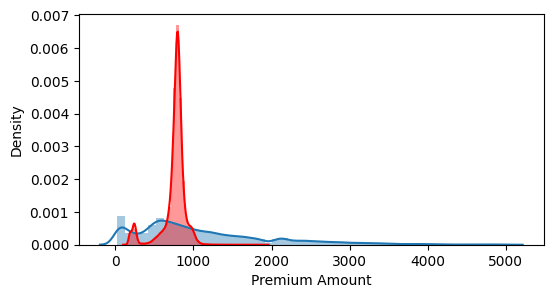

In [24]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
# sns.distplot(a=y_pred, ax=ax1)
# sns.distplot(a=y_test, ax=ax2)
# plt.show()


fig, ax = plt.subplots(figsize=(6, 3))
sns.distplot(a=np.expm1(y_test), ax=ax)
sns.distplot(a=np.expm1(y_pred), color="red", ax=ax)
plt.show()

In [ ]:
df_pred = pd.DataFrame([y_pred*4999, y_test*4999]).transpose()
df_pred = df_pred.describe()
df_pred['diff'] = df_pred[0] - df_pred[1]
df_pred['0/1'] = df_pred[0] / df_pred[1]
df_pred

In [25]:
rmsle(y_pred, y_test)

0.15828446258424655

In [26]:
rmsle(np.expm1(y_pred), np.expm1(y_test))

1.0477421797414925

In [ ]:
y_pred

In [ ]:
y_pred/y_pred.max()

In [ ]:
rmsle(y_pred - 330, y_test)

Minimum RMSLE: 1.0478174290598878
10


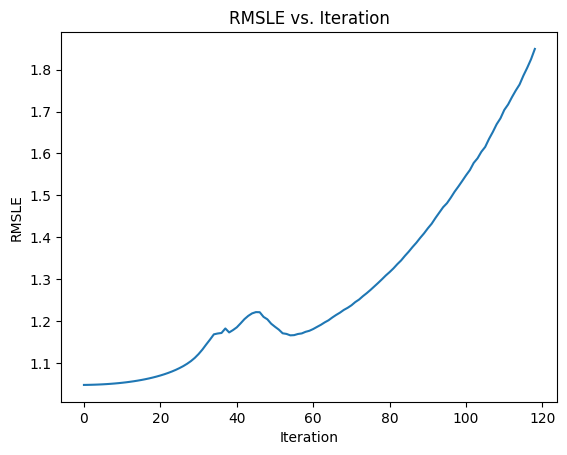

In [21]:
import matplotlib.pyplot as plt

list_ = []
min_ = 0  # Rename variable to avoid overwriting Python's built-in `min`
a = 0

# Loop through the range
for i in range(10, 601, 5):
    current_rmsle = rmsle(np.expm1(y_pred) - i, np.expm1(y_test))  # Calculate RMSLE
    list_.append(current_rmsle)  # Append current RMSLE to the list

    # Check if this RMSLE is smaller than the current minimum
    if len(list_) == 1 or current_rmsle < list_[min_]:
        min_ = len(list_) - 1  # Update `min_` to the index of the smallest value
        a = i

# Output the minimum RMSLE
print("Minimum RMSLE:", list_[min_])
print(a)

# Plot the list of RMSLE values
plt.plot(list_)
plt.xlabel("Iteration")
plt.ylabel("RMSLE")
plt.title("RMSLE vs. Iteration")
plt.show()


In [ ]:
1.0791089458874077

In [23]:
df2['Premium Amount'].max()

4999.0

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.distplot(a=df_pred['value'])

plt.subplot(1, 2, 2)
sns.distplot(a=y_test)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5), sharey=True)
plt.subplot(1, 2, 1)
plt.plot(df_pred[0][:1000])
plt.subplot(1, 2, 2)
plt.plot(df_pred[1][:1000])

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
sns.distplot(a=y_pred-10)
plt.subplot(1, 2, 2)
sns.distplot(a=y_test)
plt.show()

In [27]:
# model = NN_model
model.fit(x, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [28]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")

df_test['Gender'] = df_test['Gender'].map(gender_dict)
df_test['Policy Type'] = df_test['Policy Type'].map(policy_type_dict)
# df_test['Customer Feedback'] = df_test['Customer Feedback'].map(customer_feedback_dict)
df_test['Smoking Status'] = df_test['Smoking Status'].map(smoking_status_dict)
# df_test['Exercise Frequency'] = df_test['Exercise Frequency'].map(exercise_frequency_dict)

df_test.drop(['Policy Start Date', 'id'], axis=1, inplace=True)

df_test = pd.concat(
    [
        df_test.select_dtypes(exclude = "object"),
        pd.get_dummies(df_test['Marital Status'], dtype = int),
        pd.get_dummies(df_test['Education Level'], dtype = int).drop(['PhD'], axis=1),
        pd.get_dummies(df_test['Occupation'], dtype = int),
        pd.get_dummies(df_test['Location'], dtype = int).drop(['Suburban'], axis=1),
        pd.get_dummies(df_test['Property Type'], dtype = int).drop(['Condo'], axis=1),
        pd.get_dummies(df_test['Customer Feedback'], dtype = int),
        pd.get_dummies(df_test['Exercise Frequency'], dtype = int).drop(['Rarely'], axis=1)   
    ],
    axis = "columns"
)

# for column in df_test.columns: 
#     df_test[column] = (df_test[column]  / df_test[column].abs().max()).round(3)

def fill_nan_with_neighbors(series):
    for i in range(1, len(series) - 1):
        if pd.isna(series.iloc[i]):
            prev_value = series.iloc[i - 1]
            next_value = series.iloc[i + 1]
            if not pd.isna(prev_value) and not pd.isna(next_value):
                series.iloc[i] = (prev_value + next_value) / 2
    return series

# df_test['Previous Claims'] = fill_nan_with_neighbors(df_test['Previous Claims'])
# df_test['Credit Score'] = fill_nan_with_neighbors(df_test['Credit Score'])
# df_test['Number of Dependents'] = fill_nan_with_neighbors(df_test['Number of Dependents'])
# df_test['Health Score'] = fill_nan_with_neighbors(df_test['Health Score'])
# df_test['Annual Income'] = fill_nan_with_neighbors(df_test['Annual Income'])
# df_test['Age'] = fill_nan_with_neighbors(df_test['Age'])
# df_test['Vehicle Age'].fillna(df_test['Vehicle Age'].mean(), inplace=True)
# df_test['Insurance Duration'].fillna(df_test['Insurance Duration'].mode()[0], inplace=True)

df_test['Annual Income'] = np.log1p(df_test['Annual Income'])
df_test['Health Score'] = np.log1p(df_test['Health Score'])
df_test['Credit Score'] = np.log1p(df_test['Credit Score'])

# df_test.fillna(df_test.mean().to_dict(), inplace=True)

# df_test.isna().sum()

# x_test = df_test['Previous Claims'].values.reshape(-1, 1)

Y_pred_test = np.expm1(model.predict(df_test))

In [36]:
Y_pred_test = np.expm1(final_model.predict(df_test))

NameError: name 'df_test' is not defined

In [ ]:
Y_pred_test = model.predict(df_test)

In [ ]:
Y_pred_test = Y_pred_test - 330

In [ ]:
Y_pred_test = Y_pred_test*4999/Y_pred_test.min()
Y_pred_test

In [29]:
Y_pred_test

array([757.9165 , 826.2151 , 778.4885 , ..., 804.6654 , 786.8699 ,
       766.08655], dtype=float32)

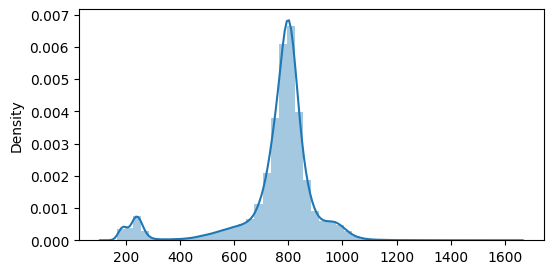

In [30]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.distplot(a=Y_pred_test, ax=ax)
# sns.distplot(a=Y_pred_test-330, color="red", ax=ax)
plt.show()

In [35]:
np.round(Y_pred_test, 3)

array([759.252, 821.279, 784.001, ..., 772.053, 761.337, 761.788],
      dtype=float32)

In [ ]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")

# for non_object_column in df_test.select_dtypes(exclude = "object").columns:
#     df_test[non_object_column] = df_test[non_object_column] / df_test[non_object_column].max()

for non_object_column in df_test.select_dtypes(exclude = "object").columns:
    df_test[non_object_column].fillna(df_test[non_object_column].mean(), inplace = True)

df_test["Policy Start Date"] = pd.to_datetime(df_test["Policy Start Date"].apply(lambda x: x[:10]))

df_test = pd.concat(
    [
        df_test.select_dtypes(exclude = "object"), 
        pd.get_dummies(df_test.select_dtypes('object'), drop_first = True, dtype = int)
    ],
    axis = "columns"
)

x_df_test = df_test.drop(['id', 'Policy Start Date'], axis = 1)

x2_df_test = x_df_test[(x_df_test['Previous Claims'] > 2) | (x_df_test['Annual Income'] > 100_000)]

# x_df_test = x_df_test[(x_df_test['Previous Claims'] <= 2) & (x_df_test['Annual Income'] <= 100_000)]

print(x_df_test.shape)
print(x2_df_test.shape)
x_df_test.head()

In [ ]:
df_test[(df_test['Previous Claims'] > 2) | (df_test['Annual Income'] > 100_000)]['Age'].count()

In [ ]:
Y_pred_test = model.predict(x_df_test)

In [ ]:
x2 = df2.drop(['Premium Amount'], axis = 1)
y2 = df2['Premium Amount']
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.2, random_state = 1)
model_2 = model4_2
model_2.fit(x2_train, y2_train)
y2_pred = model_2.predict(x2_test)

df2_pred = pd.DataFrame([y2_pred, y2_test]).transpose()
df2_pred = df2_pred.describe()
df2_pred['diff'] = df2_pred[0] - df2_pred[1]
df2_pred['0/1'] = df2_pred[0] / df2_pred[1]
df2_pred

In [ ]:
print(rmsle(y2_pred, y2_test))

In [ ]:
print(rmsle(y2_pred-401.5, y2_test))

In [ ]:
model4_2 = CatBoostRegressor(
                            # iterations=1000,
                            learning_rate=0.01,
                            depth = 9,
                            n_estimators = 1000,
                            verbose = False
)
model_2 = model4_2
model_2.fit(x2, y2)

In [ ]:
Y2_pred_test = model_2.predict(x2_df_test)

In [ ]:
Y_pred_test.size + Y2_pred_test.size

In [31]:
df_sub = pd.read_csv("/kaggle/input/playground-series-s4e12/sample_submission.csv")
df_sub.head()

,id,Premium Amount
0,1200000,1102.545
1,1200001,1102.545
2,1200002,1102.545
3,1200003,1102.545
4,1200004,1102.545


In [32]:
df_sub['Premium Amount'] = np.round(Y_pred_test, 3)
df_sub

,id,Premium Amount
0,1200000,757.916016
1,1200001,826.215027
2,1200002,778.487976
3,1200003,813.502991
4,1200004,739.442993
...,...,...
799995,1999995,986.544983
799996,1999996,617.620972
799997,1999997,804.664978
799998,1999998,786.869995


In [39]:
df_sub.iloc[0]

id                1.200000e+06
Premium Amount    7.592520e+02
Name: 0, dtype: float64

In [33]:
df_sub.to_csv("submissions1.csv", index=False)

In [ ]:
Y_pred_test = Y_pred_test - 100

# Y2_pred_test = Y2_pred_test - 401.5

In [ ]:
x_df_test['Prediction'] = Y_pred_test

x2_df_test['Prediction'] = Y2_pred_test

Y_pred_test_result = pd.concat([x_df_test, x2_df_test], axis = 'rows')['Prediction'].sort_index()

In [ ]:
Y_pred_test_result.size

In [ ]:
df_test['Premium Amount'] = Y_pred_test.round(3)
df_submission = df_test[['id', 'Premium Amount']]

print(df_submission.shape)
df_submission.head()

In [ ]:
df_submission.to_csv("submissions1.csv", index=False)

In [ ]:
df = df.sort_values(by='Premium Amount').reset_index(drop=True)
df

In [ ]:
plt.plot(df['Premium Amount'])